<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/tf2/time-series-advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Time Series / Sequences

Example, some code and a lot of inspiration taken from: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/


In [0]:
!pip install -q tf-nightly-gpu-2.0-preview

In [0]:
import tensorflow as tf
print(tf.__version__)

2.0.0-dev20190502


In [0]:
# univariate data preparation
import numpy as np

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [0]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# choose a number of time steps
n_steps = 3

# split into samples
X, y = split_sequence(raw_seq, n_steps)

# summarize the data
list(zip(X, y))

[(array([10, 20, 30]), 40),
 (array([20, 30, 40]), 50),
 (array([30, 40, 50]), 60),
 (array([40, 50, 60]), 70),
 (array([50, 60, 70]), 80),
 (array([60, 70, 80]), 90)]

In [0]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

### Multi Layer RNNs

In [0]:
# one output for each input timestep
# ideal for feeding into something that *expects* timesteps
rnn_units = 1

from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.models import Sequential, Model

model = Sequential([
    SimpleRNN(units=rnn_units, activation='relu', input_shape=(n_steps, n_features), return_sequences=True)
])

# https://keras.io/layers/recurrent/
# input: (samples, timesteps, input_dim)
# output with return_sequences: (samples, timesteps, units)

predict(model, [[10, 20, 30]])

array([[[0.],
        [0.],
        [0.]]], dtype=float32)

In [0]:
rnn_units = 50

model = Sequential([
    SimpleRNN(units=rnn_units, activation='relu', input_shape=(n_steps, n_features), return_sequences=True, name="RNN_Input"),
    SimpleRNN(units=rnn_units, activation='relu', name="RNN_Latent"),
    Dense(units=1, name="Linear_Output")
])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN_Input (SimpleRNN)        (None, 3, 50)             2600      
_________________________________________________________________
RNN_Latent (SimpleRNN)       (None, 50)                5050      
_________________________________________________________________
Linear_Output (Dense)        (None, 1)                 51        
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________


CPU times: user 2.33 s, sys: 112 ms, total: 2.44 s
Wall time: 1.56 s


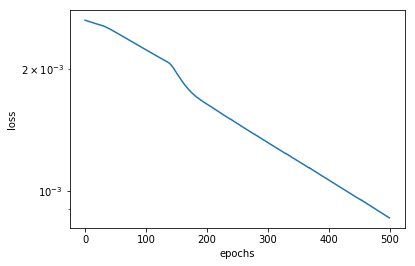

In [0]:
%time history = model.fit(X, y, epochs=500, verbose=0)

import matplotlib.pyplot as plt

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss'])

In [0]:
predict(model, [[10, 20, 30], [70, 80, 90], [100, 110, 120], [200, 210, 220], [200, 300, 400]])

array([[ 39.95612],
       [100.74844],
       [133.51225],
       [242.98866],
       [489.21252]], dtype=float32)

### LSMTs / GRUs

* mainly beneficial for long sequences
* but also 3-4 times more expensive
* might not have better results for short sequences like these

In [0]:
rnn_units = 50

model = Sequential([
    LSTM(units=rnn_units, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"),
    Dense(units=1, name="Linear_Output")
])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN_Input (LSTM)             (None, 50)                10400     
_________________________________________________________________
Linear_Output (Dense)        (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [0]:
# https://arxiv.org/ftp/arxiv/papers/1701/1701.05923.pdf
# n = output dimension
# m = input dimension
# Total number of parameters for 
# Simple RNN = n**2 + nm + n
# GRU = 3 × (n**2 + nm + n)
# LSTM = 4 × (n**2 + nm + n)

output_dimension = rnn_units
input_dimension = n_features
parameters = 4 * (output_dimension ** 2 +  output_dimension * input_dimension + output_dimension) 
parameters

10400

CPU times: user 3.13 s, sys: 108 ms, total: 3.24 s
Wall time: 2.51 s


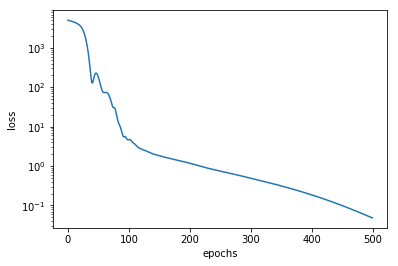

In [0]:
%time history = model.fit(X, y, epochs=500, verbose=0)

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.plot(history.history['loss'])

In [0]:
predict(model, [[10, 20, 30], [70, 80, 90], [100, 110, 120], [200, 210, 220], [200, 300, 400]])

array([[ 39.822945],
       [100.901054],
       [135.25786 ],
       [256.51852 ],
       [385.7632  ]], dtype=float32)

In [0]:
rnn_units = 50

model = Sequential([
    GRU(units=rnn_units, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"),
    Dense(units=1, name="Linear_Output")
])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN_Input (GRU)              (None, 50)                7950      
_________________________________________________________________
Linear_Output (Dense)        (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [0]:
output_dimension = rnn_units
input_dimension = n_features
parameters = 3 * (output_dimension ** 2 +  output_dimension * input_dimension + output_dimension) 
parameters

7800

CPU times: user 4.11 s, sys: 144 ms, total: 4.25 s
Wall time: 3.26 s


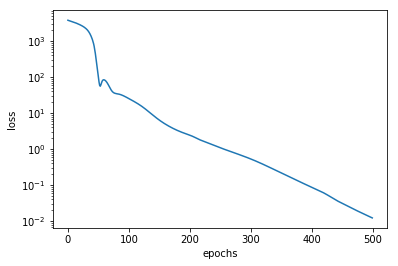

In [0]:
%time history = model.fit(X, y, epochs=500, verbose=0)

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.plot(history.history['loss'])

In [0]:
predict(model, [[10, 20, 30], [70, 80, 90], [100, 110, 120], [200, 210, 220], [200, 300, 400]])

array([[ 39.914326],
       [100.75692 ],
       [134.15837 ],
       [249.48262 ],
       [398.18933 ]], dtype=float32)

## Multivariate LSTM Models

### Multiple Input Series

In [0]:
in_seq1 = [10, 20, 30, 40, 50, 60, 70, 80, 90]
in_seq2 = [15, 25, 35, 45, 55, 65, 75, 85, 95]
out_seq = [in1 + in2 for in1, in2 in zip(in_seq1, in_seq2)]
out_seq

[25, 45, 65, 85, 105, 125, 145, 165, 185]

In [0]:
# convert to [rows, columns] structure
in_seq1 = np.array(in_seq1).reshape((len(in_seq1), 1))
in_seq2 = np.array(in_seq2).reshape((len(in_seq2), 1))
out_seq = np.array(out_seq).reshape((len(out_seq), 1))
out_seq

array([[ 25],
       [ 45],
       [ 65],
       [ 85],
       [105],
       [125],
       [145],
       [165],
       [185]])

In [0]:
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))
dataset

array([[ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])

In [0]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [0]:
# choose a number of time steps
n_steps = 3

# convert into input/output
X, y = split_sequences(dataset, n_steps)

# summarize the data
list(zip(X, y))

[(array([[10, 15],
         [20, 25],
         [30, 35]]), 65), (array([[20, 25],
         [30, 35],
         [40, 45]]), 85), (array([[30, 35],
         [40, 45],
         [50, 55]]), 105), (array([[40, 45],
         [50, 55],
         [60, 65]]), 125), (array([[50, 55],
         [60, 65],
         [70, 75]]), 145), (array([[60, 65],
         [70, 75],
         [80, 85]]), 165), (array([[70, 75],
         [80, 85],
         [90, 95]]), 185)]

In [0]:
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

# define model
model = Sequential()
model.add(GRU(units=50, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"))
model.add(Dense(units=1, name="Linear_Output"))
model.compile(optimizer='adam', loss='mse')

CPU times: user 4.26 s, sys: 154 ms, total: 4.42 s
Wall time: 3.42 s


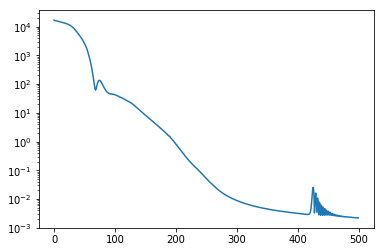

In [0]:
# fit model
%time history = model.fit(X, y, epochs=500, verbose=0)
import matplotlib.pyplot as plt

plt.yscale('log')
plt.plot(history.history['loss'])

In [0]:
def predict_multi(model, samples):
  input = np.array(samples)
  input = input.reshape(1, input.shape[0], input.shape[1])
  y_pred = model.predict(input)
  return y_pred

In [0]:
predict_multi(model, [[80, 85], [90, 95], [100, 105]])

array([[205.34448]], dtype=float32)

In [0]:
predict_multi(model, [[10, 15], [20, 25], [30, 35]])

array([[64.98211]], dtype=float32)

In [0]:
predict_multi(model, [[180, 185], [190, 195], [200, 205]])

array([[414.8397]], dtype=float32)

#### Let's make this a little bit harder

* output y can be inferred from final timestep
* now we try to infer following ouput

In [0]:
y += 20
list(zip(X, y))

[(array([[10, 15],
         [20, 25],
         [30, 35]]), 85), (array([[20, 25],
         [30, 35],
         [40, 45]]), 105), (array([[30, 35],
         [40, 45],
         [50, 55]]), 125), (array([[40, 45],
         [50, 55],
         [60, 65]]), 145), (array([[50, 55],
         [60, 65],
         [70, 75]]), 165), (array([[60, 65],
         [70, 75],
         [80, 85]]), 185), (array([[70, 75],
         [80, 85],
         [90, 95]]), 205)]

CPU times: user 11.8 s, sys: 728 ms, total: 12.5 s
Wall time: 8.34 s


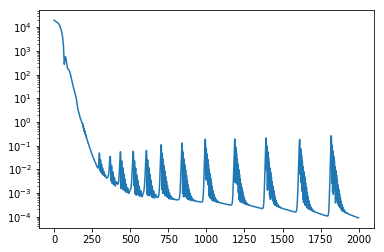

In [0]:
model = Sequential()
model.add(GRU(units=50, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"))
model.add(Dense(units=1, name="Linear_Output"))
model.compile(optimizer='adam', loss='mse')

# train a little bit longer, as this should be harder now
%time history = model.fit(X, y, epochs=2000, verbose=0)
import matplotlib.pyplot as plt

plt.yscale('log')
plt.plot(history.history['loss'])

In [0]:
predict_multi(model, [[80, 85], [90, 95], [100, 105]])

array([[225.58035]], dtype=float32)

In [0]:
predict_multi(model, [[10, 15], [20, 25], [30, 35]])

array([[85.]], dtype=float32)

In [0]:
predict_multi(model, [[180, 185], [190, 195], [200, 205]])

array([[449.7898]], dtype=float32)

## Multi-Step LSTM Models
* this might just as well be an encoder / decoder approach

In [0]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
 
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# summarize the data
for input, output in zip(X, y):
  print (input, output)

[10 20 30] [40 50]
[20 30 40] [50 60]
[30 40 50] [60 70]
[40 50 60] [70 80]
[50 60 70] [80 90]


In [0]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(GRU(100, activation='relu', input_shape=(n_steps_in, n_features)))
# model.add(GRU(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
# model.add(GRU(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

CPU times: user 4.43 s, sys: 332 ms, total: 4.77 s
Wall time: 3.52 s


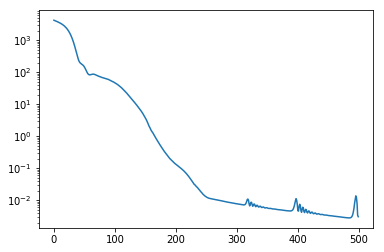

In [0]:
# fit model
%time history = model.fit(X, y, epochs=500, verbose=0)
import matplotlib.pyplot as plt

plt.yscale('log')
plt.plot(history.history['loss'])

In [0]:
X_sample = np.array([70, 80, 90]).reshape((1, n_steps_in, n_features))
y_pred = model.predict(X_sample)
print(y_pred)

[[102.141205 112.84339 ]]


In [0]:
X_sample = np.array([10, 20, 30]).reshape((1, n_steps_in, n_features))
y_pred = model.predict(X_sample)
print(y_pred)

[[39.94436 49.95082]]
